
## ポワソン混合モデルにおける推論

Populating the interactive namespace from numpy and matplotlib


/home/jimmy/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['norm', 'beta']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


(array([16., 35., 54., 61., 28.,  5.,  0.,  2.,  9., 35., 28., 53., 29.,
        17., 16.,  6.,  2.,  2.,  1.,  1.]),
 array([15.  , 18.85, 22.7 , 26.55, 30.4 , 34.25, 38.1 , 41.95, 45.8 ,
        49.65, 53.5 , 57.35, 61.2 , 65.05, 68.9 , 72.75, 76.6 , 80.45,
        84.3 , 88.15, 92.  ]),
 <a list of 20 Patch objects>)

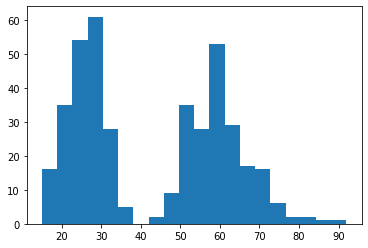

In [17]:
%pylab inline
from scipy.stats import poisson
data1 = poisson.rvs(25, size=200)
data2 = poisson.rvs(60, size=200)
x = np.concatenate([data1, data2])
plt.hist(x, bins=20)

## ガウス混合モデルにおける推論  
### データ生成
1次元ガウス混合モデルを作成
- data1
    - 平均30
    - 標準偏差5
    - データ数100
- data2
    - 平均60
    - 標準偏差値10
    - データ数300

Populating the interactive namespace from numpy and matplotlib


/home/jimmy/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['beta']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


(array([ 3.,  7., 26., 34., 26., 14.,  9., 13., 19., 26., 28., 27., 34.,
        17., 11.,  3.,  4., 39., 55.,  5.]),
 array([15.87941042, 19.97383716, 24.0682639 , 28.16269064, 32.25711738,
        36.35154413, 40.44597087, 44.54039761, 48.63482435, 52.72925109,
        56.82367784, 60.91810458, 65.01253132, 69.10695806, 73.2013848 ,
        77.29581155, 81.39023829, 85.48466503, 89.57909177, 93.67351851,
        97.76794526]),
 <a list of 20 Patch objects>)

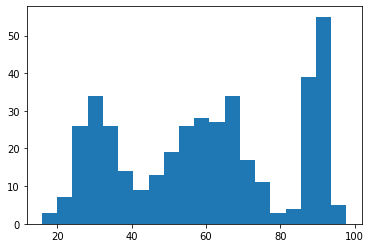

In [3]:
%pylab inline
import seaborn as sns
from scipy.stats import norm
loc_vec = [30,60,90]
scale_vec = [5,10, 3]
mix_rate = [0.25, 0.5, 0.25]
data1 = norm.rvs(loc=30, scale=5, size=100)
data2 = norm.rvs(loc=60,scale=10, size=200)
data3 = norm.rvs(loc=90,scale=3, size=100)
x = np.concatenate([data1, data2, data3]) #同じ軸でdataを結合
plt.hist(x, bins=20) #binsの数はデータ数nの平方根程度が良い(らしい)

### ギブスサンプリング
欲しいもの
$$
p( S , \mu , \Lambda , \pi | X)
$$
### S(クラスタの割り当て)のサンプリング  
$$
s_n \sim  Cat(s_n|\eta)
$$
### その他のパラメータのサンプリング 

μ ,Λ,πのサンプリングがしたい

#### μのサンプリング
$$
\mu_n \sim  N (\mu_k|\hat{m}_k, (\hat{\beta}_k \Lambda_k)^{-1})
$$
#### Λのサンプリング
$$
\Lambda_k \sim W(\Lambda_k|\hat{\mu}_k, \hat{W}_k)
$$
#### πのサンプリング
$$
\pi \sim Dir(\pi|\hat{\alpha})
$$

### １次元ガウス混合モデルのギブスサンプリング実装

In [12]:
#初期化
import numpy as np
import math
maxiter = 2
num_data = 400
num_cluster = 3
#！！！初期値要検討良い参考資料が見つかり次第修正！！！
p_loc_vec = np.zeros(num_cluster)
p_scale_vec = np.ones(num_cluster)
pi_vector = np.ones(num_cluster)/num_cluster
s_vector = np.zeros((num_data,num_cluster))
#ハイパーパラメータの初期化
eta = np.zeros((num_data, num_cluster))
alpha = 1.0
alpha_vec = np.ones(num_cluster)
beta = 1.0
v = 2
old_m_vec = np.ones(1)
m_vector = np.zeros((num_cluster,1))
w_matrix = np.identity(1)
beta_vec = np.zeros(num_cluster)

In [13]:
for i in range(maxiter):
    #sのサンプリング
    for n in range (num_data):
        for k in range(num_cluster):
            eta[n][k] = math.exp(-0.5*(x[n] - p_loc_vec[k])*p_scale_vec[k]*(x[n] - p_loc_vec[k])+ 0.5*math.log(p_scale_vec[k]) + math.log(pi_vector[k]))
    for n in range(num_data):
        nor_eta = 0
        for  k in range(num_cluster):
            nor_eta += eta[n][k]
        if nor_eta == 0:
            s_vector[n] = np.random.multinomial(1,eta[n])
        else:
            s_vector[n] = np.random.multinomial(1,eta[n]/nor_eta)
    #piのサンプリング
    for k in range(num_cluster):
        sum1 = 0
        for n in range(num_data):
            sum1 += s_vector[n][k]
        alpha_vec[k] = sum1 + alpha
    pi_vector = np.random.dirichlet(alpha_vec)
    #Λとμのサンプリング
    for k in range(num_cluster):
        sum1 = 0
        sum2 = 0
        for n in range(num_data):
            sum1 += s_vector[n][k]*x[n]
            sum2 += s_vector[n][k]
        beta_vec[k] = sum2 + beta
        m_vector[k] = (sum1 + beta*old_m_vec)/beta_vec[k]
    for k in range(num_cluster):
        sum1 = 0
        sum2 = 0
        for n in range(num_data):
            sum1 += s_vector[n][k]*x[n]*x[n]
            sum2 += s_vector[n][k]
        w_new = sum1 + beta*(old_m_vec*old_m_vec) - beta_vec[k]*(m_vector[k]*m_vector[k]) + np.linalg.inv(w_matrix)
        new_v = sum2 + v
        p_scale_vec[k] = new_v * np.linalg.inv(w_new)
        p_loc_vec[k] = np.random.normal(m_vector[k], (beta_vec[k]*p_scale_vec[k])/np.sum(beta_vec[k]*p_scale_vec[k]))

In [14]:
%pylab inline
import seaborn as sns
from scipy.stats import norm
p_loc_vec = p_loc_vec.tolist()
p_scale_vec = p_scale_vec.tolist()
pi_vector = pi_vector.tolist()
print(p_loc_vec)
print(p_scale_vec)
print(pi_vector)

Populating the interactive namespace from numpy and matplotlib
[28.116082063980087, 28.31123930401208, 37.479367865582226]
[0.19464333643968654, 0.20681785343352307, 0.004631501375173692]
[0.3903373192840632, 0.44263509804608697, 0.16702758266984977]


/home/jimmy/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['beta', 'norm']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


(array([262., 519.,  51.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 167.]),
 array([27.60086357, 28.09543571, 28.59000786, 29.08458   , 29.57915214,
        30.07372429, 30.56829643, 31.06286858, 31.55744072, 32.05201286,
        32.54658501, 33.04115715, 33.5357293 , 34.03030144, 34.52487358,
        35.01944573, 35.51401787, 36.00859001, 36.50316216, 36.9977343 ,
        37.49230645]),
 <a list of 20 Patch objects>)

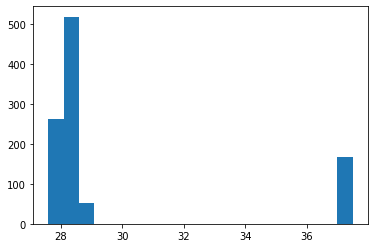

In [15]:
data1 = norm.rvs(loc=p_loc_vec[0], scale=p_scale_vec[0], size=int(pi_vector[0]*1000))
data2 = norm.rvs(loc=p_loc_vec[1], scale=p_scale_vec[1], size=int(pi_vector[1]*1000))
data3 = norm.rvs(loc=p_loc_vec[2], scale=p_scale_vec[2], size=int(pi_vector[2]*1000))
x = np.concatenate([data1, data2, data3]) #同じ軸でdataを結合
plt.hist(x, bins=20) #binsの数はデータ数nの平方根程度が良い(らしい)

(array([100.,  85., 115.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 100.]),
 array([26.20993172, 27.59183628, 28.97374085, 30.35564541, 31.73754997,
        33.11945453, 34.5013591 , 35.88326366, 37.26516822, 38.64707278,
        40.02897735, 41.41088191, 42.79278647, 44.17469103, 45.5565956 ,
        46.93850016, 48.32040472, 49.70230928, 51.08421385, 52.46611841,
        53.84802297]),
 <a list of 20 Patch objects>)

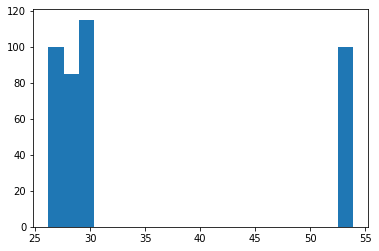

In [46]:
data1 = norm.rvs(loc=p_loc_vec[0], scale=p_scale_vec[0], size=100)
data2 = norm.rvs(loc=p_loc_vec[1], scale=p_scale_vec[1], size=200)
data3 = norm.rvs(loc=p_loc_vec[2], scale=p_scale_vec[2], size=100)
x = np.concatenate([data1, data2, data3]) #同じ軸でdataを結合
plt.hist(x, bins=20) #binsの数はデータ数nの平方根程度が良い(らしい)

逆行列の周辺怪しい
sumを求めるのには内包表記で
更新する値としない値を
変数名を本に合わせておく
デバックで同時にコードを綺麗にしていくとバグ